## Introduction to NLP Fundamentals in Tensorflow

NLP has the goal of deriving information out of natural language (could be sequence text or speech)

Another common term for NLP problems is sequence to sequnce poblems (seq2seq)

In [1]:
# Check for GPU usage
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-04370c6c-d270-ded5-3e7b-6f5a505c3260)


## Get helper functions


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-10 11:23:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-10 11:23:53 (114 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves,compare_historys


## Get a text dataset
The dataset we are going to use is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster)

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2023-09-10 11:23:57--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K   711KB/s    in 0.8s    

2023-09-10 11:23:58 (711 KB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
unzip_data("/content/nlp_getting_started.zip")

## Visualize a text dataset

To visualize our text sample, we first have to read them in.

In [6]:
import pandas as pd
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
# What does the test data look like ?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# How many examples of each class
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
# How many total samples
len(train_df), len(test_df)

(7613, 3263)

In [11]:
# Let's visualize some random training examples
import random
random_index = random.randint(0,len(train_df)-5) # create number indexes not higher than total number of the data
for row in train_df_shuffled[["text","target"] ][random_index : random_index +5 ].itertuples():
  _,text,target = row
  print(f"Target : {target}"," (real disaster)" if target > 0 else "not real disaster")
  print(f"Text \n{text}\n")
  print("---\n")

Target : 1  (real disaster)
Text 
'Planted 390 years ago' it was moved to U-S. This Bonsai Survived Hiroshima But Its Story Was Nearly Lost http://t.co/jID4RO34gb via @NatGeo

---

Target : 0 not real disaster
Text 
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'

---

Target : 0 not real disaster
Text 
It should be our duty to obliterate superstition from our society : Swami Agnivesh

---

Target : 0 not real disaster
Text 
#IranDeal most members of Congress who don't want this deal don't have any kids who would b coming home in body bags. War makes them money

---

Target : 0 not real disaster
Text 
Cherry print + matching lipstick (just rediscovered NarsÛª Û÷Heat WaveÛª).?? by @emilyschuman http://t.co/4eGh1G1Jk7

---



### Split data into training and validation sets

In [12]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            random_state=42,
                                                                            test_size=0.1)

val_sentences.shape, val_labels.shape,train_sentences.shape,train_labels.shape

((762,), (762,), (6851,), (6851,))

In [13]:
# Check the lengths
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [14]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

# Converting text into numbers

When dealing with a text problem, one of the fşrst things you will have to do before you can build a model is to convert your text to numbers

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

## Text Vectorization (Tokenization)

In [15]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize ="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None # how long do you want your sequences to be?

                                    )


In [17]:
# find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [18]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length = max_length
                                    )

In [19]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [20]:
# Create a sample sentence and tokenize it
sample_sentence = "There is a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
random_sentence

"do he love me do he love me not I ain't a playa I just crush a lot"

In [22]:
text_vectorizer(random_sentence)

<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([  68,   56,  110,   31,   68,   56,  110,   31,   34,    8,  865,
          3, 9734,    8,   29])>

In [23]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:]
len(words_in_vocab)

10000

In [24]:
top_5_words

['', '[UNK]', 'the', 'a', 'in']

In [25]:
bottom_5_words

['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']

### Creating an Embedding using an Embedding layer

To make our embeddings, we are going to use TensorFlow's embedding layer

The parameters we care about for our embedding layer:
* input_dim = the size of our vocabulary
* output_dim = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* input_length = length of the the seqeunces being passed to the embedding layer

In [26]:
from tensorflow.keras import layers
embedding_layer = layers.Embedding(input_dim = max_vocab_length, # set input shape
                                   output_dim = 128,
                                   input_length = max_length, # how long is each input
                                   )

embedding_layer

In [27]:
# Get a random sentence from the training_sentences
random_sentence = random.choice(train_sentences)
random_sentence

'Correction: Tent Collapse Story http://t.co/jXs50FkviK'

In [28]:
# turn it into numerical format via text_vectorizer
number_random_sentence = text_vectorizer([random_sentence])
number_random_sentence

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[3969, 1751,  155,  451,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [29]:
# pass number_sentence to the embedding layer
sample_embed = embedding_layer(number_random_sentence)
sample_embed

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00131357,  0.03277893,  0.03318212, ...,  0.04267197,
         -0.01816084,  0.04945382],
        [-0.00770504, -0.0236834 , -0.03538655, ..., -0.02987807,
         -0.0158134 ,  0.03485319],
        [ 0.04014983, -0.03164034,  0.00968494, ..., -0.03586734,
          0.01707456, -0.04102612],
        ...,
        [-0.02176207,  0.0183563 , -0.02060653, ...,  0.02676134,
          0.01067667, -0.00472445],
        [-0.02176207,  0.0183563 , -0.02060653, ...,  0.02676134,
          0.01067667, -0.00472445],
        [-0.02176207,  0.0183563 , -0.02060653, ...,  0.02676134,
          0.01067667, -0.00472445]]], dtype=float32)>

In [30]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.00131357,  0.03277893,  0.03318212,  0.04393617,  0.02647272,
        -0.01767858, -0.03098936,  0.01585115, -0.00151954, -0.02067378,
         0.02283916, -0.02468269, -0.0246041 ,  0.03561142,  0.02100578,
        -0.01894461, -0.04955374,  0.00826389, -0.04097581, -0.01455289,
         0.04643044,  0.00488959, -0.03080687, -0.0245763 , -0.04632689,
         0.04858983, -0.00232809, -0.01483367, -0.04192761,  0.01042352,
        -0.01790394,  0.02704307,  0.03943205, -0.03230264,  0.00482106,
         0.02736876,  0.04379379,  0.00456264,  0.02194388,  0.036561  ,
         0.01663767,  0.01118034,  0.03459393,  0.00786322, -0.01511885,
         0.04687252,  0.00060974,  0.01190176, -0.01613283,  0.03466416,
        -0.0036171 , -0.00223039, -0.02001514,  0.0310015 ,  0.01534813,
        -0.02624713,  0.00344454,  0.03129068,  0.01543312, -0.02758207,
         0.02786208, -0.03453183,  0.00399724,  0.04270676, -0.01469008,
  

## Modelling a text dataset (running a series of experiments)

Now we have got a way to turn our text sequences into numbers,
it is time to start building a series of modelling experiments

We will start with a baseline and move on from there.

* Model 0 : Naive Bayes (baseline)
* Model 1 : Feed-forward neural networks (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model  (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these ?

Use standard steps in modelling with tensorflow:

* Create a model
* Compile and Fit the Model
* Evaluate the Model

### Model 0 : Getting a baseline

As with all machine learning modelling experiments, it is important to create a baseline  model so you have go a benchmark for future experients to build upon.

To create our baseline, we will use Sklearn' Naive Bayes using th TF-IDF formula to convert our words to numbers

**Note :** it is common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon on them


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                   ("tfidf",TfidfVectorizer()), # converts words to numbers and using tfidf
                   ("clf",MultinomialNB()), # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [32]:
# Evaluate the baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model score {baseline_score*100:.2f}")

Our baseline model score 79.27


In [33]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [34]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

Let's create one to compare our model's predictions with the truth labels using the folllowing metrics:

* Accuracy
* Precision
* Recall
* F1-score



In [35]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true,y_pred):
  """
  Calculates model accuracy, precision, recall and f1-score of a binary classification model.
  """

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true,y_pred)*100
  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1,_ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1_score": model_f1}

  return model_results


In [36]:
# Get baseline results
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

### Model 1: A simple Dense Model

In [37]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [38]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding_layer(x) # Create an embedding of the numberized inputs
x = tf.keras.layers.GlobalAveragePooling1D()(x) # condense the feature vector fpr each token to one vector
outputs = layers.Dense(1,activation="sigmoid")(x) # Create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs,outputs,name="model_1_Dense"
)

In [39]:
model_1.summary()

Model: "model_1_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [40]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

In [41]:
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data = (val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_Dense")]
                              )


Saving TensorBoard log files to: model_logs/model_1_Dense/20230910-112405
Epoch 1/5
215/215 [==============================] - 34s 123ms/step - loss: 0.6119 - accuracy: 0.6930 - val_loss: 0.5361 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 6s 26ms/step - loss: 0.4417 - accuracy: 0.8192 - val_loss: 0.4673 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3474 - accuracy: 0.8578 - val_loss: 0.4597 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2843 - accuracy: 0.8930 - val_loss: 0.4674 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2373 - accuracy: 0.9120 - val_loss: 0.4818 - val_accuracy: 0.7861


In [42]:
# Check the results
model_1.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 7ms/step - loss: 0.4818 - accuracy: 0.7861


[0.4818057119846344, 0.7860892415046692]

In [43]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 1s 7ms/step


(762, 1)

In [44]:
model_1_pred_probs[:10]

array([[0.3665742 ],
       [0.81565684],
       [0.99752885],
       [0.10851809],
       [0.12064415],
       [0.9376137 ],
       [0.9146714 ],
       [0.9919194 ],
       [0.97004247],
       [0.24717642]], dtype=float32)

In [45]:
val_labels

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,

In [46]:
# Convert model predictions probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [47]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                            y_pred = model_1_preds)

model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7911704681403405,
 'recall': 0.7860892388451444,
 'f1_score': 0.7830068921982195}

In [48]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

## Visualizing Learned Embeddings

To visualize the model go to this tensorflow embedding website : https://projector.tensorflow.org/

In [49]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [50]:
model_1.summary()

Model: "model_1_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [51]:
# Get the weight  matrix of embedding layer
# (these are the numerical representation of each token in our training data)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape

(10000, 128)

In [52]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [53]:
# Download files from Colab to upload projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN)

RNN's are useful for seqeunce data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of RNN typically looks like this:

Input(text) -> Tokenize -> Embedding -> Layers (RNN's/Dense) -> Output (label probability)

In [54]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(name="Input_layer",shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding_layer(x)
#x = layers.LSTM(units=64, return_sequences=True)(x) # when you are stacking RNN cells together, you need to return_squences = True
x = layers.LSTM(64)(x) # default acivation function is tanh
#x = layers.Dense(64,activation="relu")(x)
outputs = layers.Dense(1,name="output_layer",activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs,outputs,name="model_2_LSTM")

In [55]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [56]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

In [57]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data = (val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_2_LSTM")]
                              )

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230910-112532
Epoch 1/5
215/215 [==============================] - 21s 72ms/step - loss: 0.2251 - accuracy: 0.9177 - val_loss: 0.5926 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 0.1583 - accuracy: 0.9422 - val_loss: 0.6120 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 2s 12ms/step - loss: 0.1277 - accuracy: 0.9537 - val_loss: 0.6785 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1072 - accuracy: 0.9613 - val_loss: 0.7571 - val_accuracy: 0.7953
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0877 - accuracy: 0.9675 - val_loss: 0.9128 - val_accuracy: 0.7743


In [58]:
# Make predictions with LSTM model
model_2_preds_probs = model_2.predict(val_sentences)
model_2_preds_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[6.6289883e-03],
       [9.0590012e-01],
       [9.9973005e-01],
       [4.3864153e-02],
       [5.3412240e-04],
       [9.9684143e-01],
       [7.9792744e-01],
       [9.9979311e-01],
       [9.9967587e-01],
       [5.6199300e-01]], dtype=float32)

In [59]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_preds_probs))
model_2_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [60]:
# Calculate the model_2 results
model_2_results = calculate_results(val_labels,model_2_preds)
model_2_results

{'accuracy': 77.42782152230971,
 'precision': 0.7752857985262857,
 'recall': 0.7742782152230971,
 'f1_score': 0.7725974162749719}

In [61]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

In [62]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string,name="Input_layer")
x = text_vectorizer(inputs)
x = embedding_layer(x)
#x = layers.GRU(64, return_sequences=True)(x) # if you want to stack recurrent layers on top each other you need to return_sequences=True
#x = layers.LSTM(64,return_sequences=True)(x)
#x = layers.GRU(64)(x)
#x = layers.Dense(64,activation="relu")(x)
#x = layers.GlobalAveragePooling1D()(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1,name="output_layer",activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs,outputs,name="model_3_GRU")

In [63]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [64]:
# Compile the model
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

In [65]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data = (val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_3_GRU")]
                              )

Saving TensorBoard log files to: model_logs/model_3_GRU/20230910-112618
Epoch 1/5
215/215 [==============================] - 21s 79ms/step - loss: 0.1594 - accuracy: 0.9368 - val_loss: 0.6918 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0845 - accuracy: 0.9683 - val_loss: 0.8736 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0698 - accuracy: 0.9731 - val_loss: 0.9409 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0628 - accuracy: 0.9743 - val_loss: 0.9410 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0519 - accuracy: 0.9778 - val_loss: 1.2016 - val_accuracy: 0.7782


In [66]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[6.8574975e-04],
       [8.0545813e-01],
       [9.9961448e-01],
       [4.8808776e-02],
       [7.2669216e-05],
       [9.9943537e-01],
       [4.4791675e-01],
       [9.9981731e-01],
       [9.9974912e-01],
       [8.2881176e-01]], dtype=float32)

In [67]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [68]:
# Calvulate results model_3
model_3_results = calculate_results(val_labels,model_3_preds)
model_3_results

{'accuracy': 77.82152230971128,
 'precision': 0.7810722984564322,
 'recall': 0.7782152230971129,
 'f1_score': 0.7757459581978545}

In [69]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right. However, a bidirectional RNN goes from right to left as well as
from left to right

In [70]:
# Build a  bidirectional RNN
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,), name="Input_layer", dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding_layer(x)
#x = layers.Bidirectional(layers.LSTM(64,return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs,outputs,name="model_4_bidirectional")

In [71]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [72]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

In [73]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data = (val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_4_Bidirectional")]
                              )

Saving TensorBoard log files to: model_logs/model_4_Bidirectional/20230910-112706
Epoch 1/5
215/215 [==============================] - 29s 91ms/step - loss: 0.1099 - accuracy: 0.9657 - val_loss: 1.0488 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0524 - accuracy: 0.9778 - val_loss: 1.3360 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0462 - accuracy: 0.9791 - val_loss: 1.2094 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 2s 12ms/step - loss: 0.0412 - accuracy: 0.9803 - val_loss: 1.1576 - val_accuracy: 0.7546
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0421 - accuracy: 0.9804 - val_loss: 1.3927 - val_accuracy: 0.7690


In [74]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[8.6004078e-01],
       [5.8821517e-01],
       [9.9997032e-01],
       [2.0867723e-01],
       [1.1276479e-05],
       [9.9975246e-01],
       [4.5522511e-01],
       [9.9999106e-01],
       [9.9997234e-01],
       [7.2086573e-01]], dtype=float32)

In [75]:
# Convert model 4 pred probs to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0

In [76]:
# Calvulate results model_3
model_4_results = calculate_results(val_labels,model_4_preds)
model_4_results

{'accuracy': 76.9028871391076,
 'precision': 0.7701356893081864,
 'recall': 0.7690288713910761,
 'f1_score': 0.7671875324347506}

## Convolutional Neural Networks for Text (and other types of sequences)

We have used CNN's for images but images are typically 2D. However, our text data is 1D

Previously we used Conv2D for our images, but we will use Conv1D for text data

The typical structure of a Conv1D model for sequence (in our case text):

'''
Inputs (text) -> Tokenization -> Embedding -> Layer(s) ->(typically Conv1D + pooling) -> Outputs (class probabilities)



## Model 5 : Conv1D

In [77]:
# Test out our embedding layer, Conv1D layer and max poolinga
embedding_test = embedding_layer(text_vectorizer(["this is a test sentence"])) # turn target into embedding

conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation="relu",
                        padding ="valid"
                        )
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important feature


embedding_test.shape, conv_1d_output.shape,max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [78]:
# Create 1-dimensional convolutional layer to model sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding_layer(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation="relu",
                  padding="valid",
                  strides=1
                  )(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1,activation="sigmoid",)(x)
model_5 = tf.keras.Model(inputs,outputs,name="model_5_conv1d")

# Compile
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )


In [79]:
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 1)              

In [80]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_5_Conv1D")]
                              )

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20230910-112801
Epoch 1/5
215/215 [==============================] - 17s 65ms/step - loss: 0.1232 - accuracy: 0.9623 - val_loss: 0.8861 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 4s 16ms/step - loss: 0.0751 - accuracy: 0.9705 - val_loss: 1.0255 - val_accuracy: 0.7585
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0617 - accuracy: 0.9768 - val_loss: 1.0950 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0543 - accuracy: 0.9772 - val_loss: 1.1540 - val_accuracy: 0.7480
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0507 - accuracy: 0.9785 - val_loss: 1.2757 - val_accuracy: 0.7559


In [81]:
# Make some predictions with our Conv1D model
model_5_pred_probs=model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[1.24356754e-01],
       [1.19309053e-01],
       [9.99837279e-01],
       [7.82227069e-02],
       [5.62908497e-07],
       [9.93214011e-01],
       [9.28365767e-01],
       [9.99889970e-01],
       [9.99999404e-01],
       [8.65378797e-01]], dtype=float32)

In [82]:
# Convert to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [83]:
# Calculate results
model_5_results = calculate_results(val_labels,model_5_preds)
model_5_results

{'accuracy': 75.59055118110236,
 'precision': 0.7562023016353725,
 'recall': 0.7559055118110236,
 'f1_score': 0.75433369124314}

In [84]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

## Model 6 : TensorFlow Hub Pretrained Sentence Encoder

Now, we have built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Encoder

In [85]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "  When you call the universal sentence encoder on a sentence, it turns it into number "])


In [86]:
print(embed_samples[0][:50])

tf.Tensor(
[-0.01602836  0.01068853  0.02425464 -0.01405768  0.01434428  0.08292627
  0.01963369  0.0616014  -0.00352701 -0.01216415  0.00978648 -0.01248499
  0.01232347  0.09748451  0.06141111 -0.03728352  0.01860887 -0.04669851
  0.00413913 -0.06363907 -0.02469896  0.02713692  0.02284444 -0.0021003
 -0.00630591 -0.0396496   0.02220407  0.00115075 -0.03132181  0.00119527
 -0.04012549  0.04561895 -0.01530597 -0.00175914  0.02173133 -0.08450424
  0.03340027  0.04604555 -0.0248025  -0.08681662  0.00702696 -0.00770477
 -0.01434536  0.07814164 -0.10676058 -0.05152996 -0.00858159 -0.0323223
 -0.03871096  0.02581471], shape=(50,), dtype=float32)


In [87]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape =[],
                                        dtype=tf.string,
                                        trainable = False,
                                        name="USE"
                                        )


In [88]:
# Create the model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")
], name = "model_6")

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

In [89]:
model_6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [90]:
# Fit the model
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data = (val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_6_hub_USE")]
                              )

Saving TensorBoard log files to: model_logs/model_6_hub_USE/20230910-112927
Epoch 1/5
215/215 [==============================] - 8s 17ms/step - loss: 0.5047 - accuracy: 0.7853 - val_loss: 0.4533 - val_accuracy: 0.7953
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.4145 - accuracy: 0.8142 - val_loss: 0.4410 - val_accuracy: 0.8071
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4009 - accuracy: 0.8194 - val_loss: 0.4377 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.3929 - accuracy: 0.8263 - val_loss: 0.4357 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 6s 28ms/step - loss: 0.3868 - accuracy: 0.8298 - val_loss: 0.4269 - val_accuracy: 0.8189


In [91]:
# Make predictions with USE TF Hub Model
model_6_pred_probs=model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.18476532],
       [0.8057101 ],
       [0.9858856 ],
       [0.21182927],
       [0.7794669 ],
       [0.73112977],
       [0.98168427],
       [0.9751688 ],
       [0.9447616 ],
       [0.09336051]], dtype=float32)

In [92]:
# Convert them
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [93]:
# Calculate results
model_6_results = calculate_results(val_labels,model_6_preds)
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8196605460013572,
 'recall': 0.8188976377952756,
 'f1_score': 0.817984880977007}

In [94]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

## Model 7: TF Hub Pretrained USE buth with 10% of the training data

Transfer Learning really helps when you do not have a large dataset

To see how our model performs on a smaller dataset, let's replicate model_6 except we will train it on 10% of the data



In [95]:
## NOTE : Making data splits like below leads to data leakage (model_7 trained on 10% of data, outperformed model_6 trained on full data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

# Create subsets of 10% of the training data
#train_10_percent = train_df_shuffled[["text","target"]].sample(frac=0.1, random_state=42)
#train_sentences_10_percent = train_10_percent["text"].to_list()
#train_labels_10_percent =train_10_percent["target"].to_list()

In [96]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [97]:
# Let's build a model as model 6
# Create the model using the Sequential API
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")
], name = "model_7")


In [98]:
model_7.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [99]:
# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

# Fit the model
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              validation_data = [val_sentences,val_labels],
                              epochs=5,
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_7_with_10_percent")]
                              )


Saving TensorBoard log files to: model_logs/model_7_with_10_percent/20230910-113013
Epoch 1/5
22/22 [==============================] - 3s 53ms/step - loss: 0.6692 - accuracy: 0.7109 - val_loss: 0.6520 - val_accuracy: 0.7231
Epoch 2/5
22/22 [==============================] - 0s 23ms/step - loss: 0.6055 - accuracy: 0.8058 - val_loss: 0.5960 - val_accuracy: 0.7651
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5325 - accuracy: 0.8219 - val_loss: 0.5434 - val_accuracy: 0.7703
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4701 - accuracy: 0.8190 - val_loss: 0.5105 - val_accuracy: 0.7743
Epoch 5/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4275 - accuracy: 0.8336 - val_loss: 0.4965 - val_accuracy: 0.7795


In [100]:
# Make predictions
model_7_pred_probs = model_7.predict(val_sentences)

24/24 [==============================] - 1s 9ms/step


In [101]:
# Conver it
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [102]:
# Calculate results
model_7_results = calculate_results(val_labels,model_7_preds)
model_7_results

{'accuracy': 77.95275590551181,
 'precision': 0.7819506047193071,
 'recall': 0.7795275590551181,
 'f1_score': 0.7772730329412364}

In [103]:
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8196605460013572,
 'recall': 0.8188976377952756,
 'f1_score': 0.817984880977007}

## Comparing the performance of each of our models

In [104]:
# Compare all our results
all_model_results = pd.DataFrame({"0_baseline":baseline_results,
                                 "1_simple_dense": model_1_results,
                                 "2_lstm":model_2_results,
                                 "3_gru":model_3_results,
                                 "4_bidirectional":model_4_results,
                                 "5_conv1D":model_5_results,
                                  "6_tf_hub_use_encoder":model_6_results,
                                  "7_tf_hub_10_percent": model_7_results}
                                 )
all_model_results=all_model_results.transpose()

In [105]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [106]:
all_model_results

,accuracy,precision,recall,f1_score
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.786089,0.791170,0.786089,0.783007
2_lstm,0.774278,0.775286,0.774278,0.772597
3_gru,0.778215,0.781072,0.778215,0.775746
4_bidirectional,0.769029,0.770136,0.769029,0.767188
5_conv1D,0.755906,0.756202,0.755906,0.754334
6_tf_hub_use_encoder,0.818898,0.819661,0.818898,0.817985
7_tf_hub_10_percent,0.779528,0.781951,0.779528,0.777273


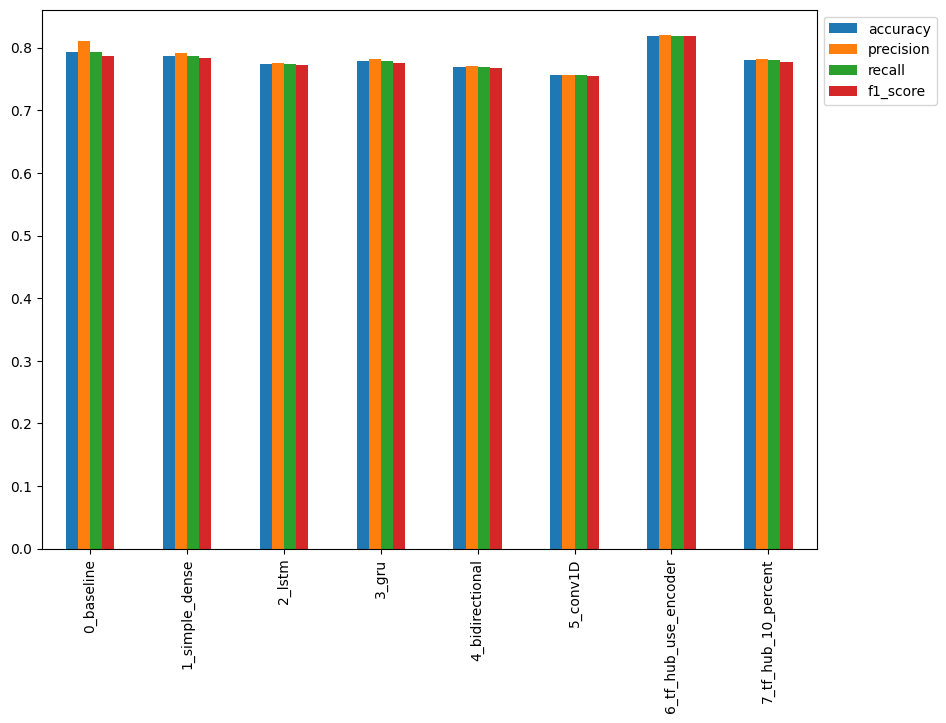

In [107]:
#Plot and compare all of the model results
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

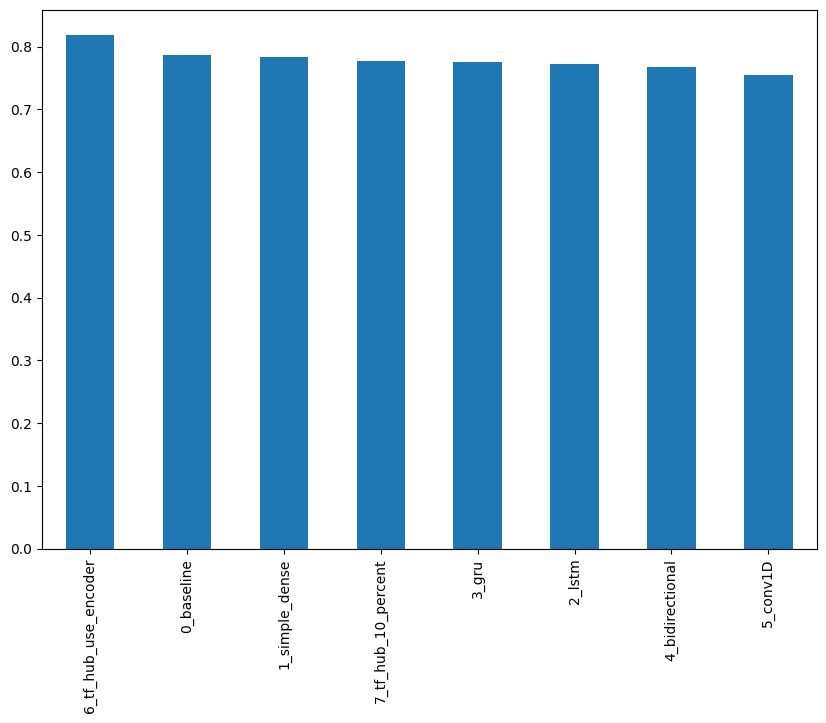

In [108]:
# Sort model results by f1-score
all_model_results.sort_values("f1_score",ascending=False)["f1_score"].plot(kind="bar",figsize=(10,7))

## Uploading our model training logs to TensorBoard.dev

In [109]:
# View TensorBoard logs of transfer learning modelling experiments
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modelling Experiments" \
  --description "Comparing multiple differebt types of model architectures on the Kaggle tweet text classification"\
  --one_shot

2023-09-10 11:30:23.483105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO


## Saving and loading a trained model

There are three main formats to save a model to in Tensorflow:

1. The keras format (default one)
2. The SavedModel format
3. The HDF5 format

In [110]:
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8196605460013572,
 'recall': 0.8188976377952756,
 'f1_score': 0.817984880977007}

In [111]:
# Save the TF Hub sentence Encoder model to HDF5 format
model_6.save("/content/drive/MyDrive/Saved_TensorFlow_Models/NLP_model_6",save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [112]:
# Load model with custoö Hub Layer (required HDF5 Format)
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Saved_TensorFlow_Models/NLP_model_6",
                                          custom_objects = {"KerasLayer": hub.KerasLayer}
                                          )

In [113]:
# How does our loaded model perform
loaded_model.evaluate(val_sentences,val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4269 - accuracy: 0.8189


[0.42688417434692383, 0.8188976645469666]

In [114]:
# Now let's save to the SavedModel forma
model_6.save("/content/drive/MyDrive/Saved_TensorFlow_Models/NLP_model_5_SavedModel",
             save_format="tf"
             )

In [115]:
load_saved_model_6 = tf.keras.models.load_model("/content/drive/MyDrive/Saved_TensorFlow_Models/NLP_model_5_SavedModel")

In [116]:
load_saved_model_6.evaluate(val_sentences,val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4269 - accuracy: 0.8189


[0.42688417434692383, 0.8188976645469666]

## Finding the most wrong examples

* If our best model still is not perfect, what examples is it getting wrong ?

* An of these wrong examples which ones is it getting *most*
wrong (thıs will prediction probabilities closest to the opposite class)

For example, if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 close to 1 and vice versa.


In [117]:
# Download a pretrained model from google
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip

--2023-09-10 11:31:28--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  17.9MB/s    in 74s     

2023-09-10 11:32:43 (12.4 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]



In [118]:
unzip_data("/content/08_model_6_USE_feature_extractor.zip")

In [120]:
# Import previously trained model from google storage
model_6_pretrained = tf.keras.models.load_model("/content/08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences,val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4272 - accuracy: 0.8163


In [121]:
# Make predictions with loaded model
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)

24/24 [==============================] - 1s 10ms/step


In [123]:
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))

In [128]:
# Create DataFrame with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text":val_sentences,
                      "target":val_labels,
                      "pred":model_6_pretrained_preds,
                      "pred_probs":tf.squeeze(model_6_pretrained_pred_probs)}
                       )
val_df.head()

,text,target,pred,pred_probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [129]:
# Find the wrong predictions and sort by predictions probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_probs",ascending=False)
most_wrong

,text,target,pred,pred_probs
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
...,...,...,...,...
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949


In [130]:
# Check the false positive (model predict 1 when should have been 0)
for row in most_wrong[:10].itertuples():
  _, text,target,pred,pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text : \n {text} \n")
  print("---")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text : 
 ? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying 

---
Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text : 
 FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J 

---
Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text : 
 @noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME. 

---
Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text : 
 Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0 

---
Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text : 
 @AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans. 

---
Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text : 
 @SonofLiberty357 all illuminated by the brightly burning buildings all around th

In [132]:
# Check the false negatives (model predict 0 when should have been 1)
for row in most_wrong[-10:].itertuples():
  _, text,target,pred,pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text : \n {text} \n")
  print("---")

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text : 
 @DavidVonderhaar At least you were sincere ?? 

---
Target: 1, Pred: 0.0, Prob: 0.05507583171129227
Text : 
 @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu 

---
Target: 1, Pred: 0.0, Prob: 0.05460337549448013
Text : 
 Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets 

---
Target: 1, Pred: 0.0, Prob: 0.054597001522779465
Text : 
 going to redo my nails and watch behind the scenes of desolation of smaug ayyy 

---
Target: 1, Pred: 0.0, Prob: 0.049637261778116226
Text : 
 You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you. 

---
Target: 1, Pred: 0.0, Prob: 0.04391848295927048
Text : 
 @SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren 

---
Target: 1, Pred: 0

##  Making predictions on the test dataset

In [136]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences,10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expect its input as list
  pred = tf.round(pred_prob)
  print(f"Pred {pred}, Pred_prob: {pred_prob}")
  print(f"Text: \n {test_sample}\n")

1/1 [==============================] - 0s 71ms/step
Pred 1.0, Pred_prob: 0.9855485558509827
Text: 
 Three Israeli soldiers wounded in West Bank terrorist attack - Haaretz http://t.co/Mwd1iPMoWT #world

1/1 [==============================] - 0s 60ms/step
Pred 0.0, Pred_prob: 0.40802714228630066
Text: 
 Yeah it actually is this whole week we in a heat wave :( https://t.co/cB2NWtGy47

1/1 [==============================] - 0s 159ms/step
Pred 1.0, Pred_prob: 0.9085261225700378
Text: 
 The day of death destruction chaos; 60000 to 80000 people were killed instantly. Please take sometime to remember and think about others

1/1 [==============================] - 0s 179ms/step
Pred 0.0, Pred_prob: 0.31961360573768616
Text: 
 @DANNYonPC @YouTube Its engineer only again so 2 1000+ rpm weapons = no thanks

1/1 [==============================] - 0s 75ms/step
Pred 1.0, Pred_prob: 0.7554843425750732
Text: 
 @LogitechG BUT THEN THE FIRE NATION ATTACKED....

1/1 [==============================] - 0s 37

## The speed/score TradeOff

In [137]:
# Let's make a function to measure the time of the prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples
  """
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time
  time_per_pred = total_time / len(samples)

  return total_time, time_per_pred

In [139]:
# Calculate TF Hub model Encoder time per pred
model_6_pretrained_pred_time, model_6_pretrained_per_pred_time = pred_timer(model_6_pretrained, val_sentences)

24/24 [==============================] - 0s 16ms/step


In [140]:
model_6_pretrained_pred_time, model_6_pretrained_per_pred_time

(0.5093504159999611, 0.0006684388661416812)

In [141]:
# Calculate our baseline model times per pred
baseline_pred_time, baseline_per_pred_time = pred_timer(model_0, val_sentences)

In [142]:
baseline_pred_time, baseline_per_pred_time

(0.028651481999986572, 3.7600370078722535e-05)